In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Merge, Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn_keras as iso

from aparent_losses import *


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [48]:
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def letterAt(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    fp = FontProperties(family="Ubuntu", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_seqprop_logo(pwm, iso_pred, cut_pred, annotate_peaks=None, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, usage_unit='log', plot_start=0, plot_end=164, save_figs=False, fig_name=None, fig_dpi=300) :

    n_samples = pwm.shape[0]
    
    #Slice according to seq trim index
    pwm = pwm[:, plot_start: plot_end, :]
    cut_pred = cut_pred[:, plot_start: plot_end]
    sequence_template = sequence_template[plot_start: plot_end]
    
    iso_pred = np.mean(iso_pred, axis=0)
    cut_pred = np.mean(cut_pred, axis=0)
    pwm = np.sum(pwm, axis=0)
    
    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])
    
    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[width_ratios[0], width_ratios[-1]], height_ratios=[1, 1])
    
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    
    plt.sca(ax0)
    plt.axis('off')
    plt.sca(ax2)
    plt.axis('off')
    
    
    annot_text = 'Samples = ' + str(int(n_samples))
    annot_text += '\nUsage = ' + str(round(iso_pred[0], 4))#annot_text += '\nUsage = ' + str(round(np.sum(cut_pred), 4))
        
    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    l2, = ax1.plot(np.arange(plot_end - plot_start), cut_pred, linewidth=3, linestyle='-', label='Predicted', color='red', alpha=0.7)
    
    if annotate_peaks is not None :
        objective_pos = 0
        if annotate_peaks == 'max' :
            objective_pos = np.argmax(cut_pred)
        else :
            objective_pos = annotate_peaks - plot_start
        
        annot_text = '(CSE+' + str(objective_pos + plot_start - 76 + 1) + ') ' + str(int(round(cut_pred[objective_pos] * 100, 0))) + '% Cleavage'
        ax1.annotate(annot_text, xy=(objective_pos, cut_pred[objective_pos]), xycoords='data', xytext=(-30, -5), ha='right', fontsize=10, weight="bold", color='black', textcoords='offset points', arrowprops=dict(connectionstyle="arc3,rad=-.1", headlength=8, headwidth=8, shrink=0.15, width=1.5, color='black'))
    
    plt.sca(ax1)

    plt.xlim((0, plot_end - plot_start))
    #plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.legend(handles=[l2], fontsize=12, prop=dict(weight='bold'), frameon=False)
    plt.axis('off')
    
    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    #ax[0].plot([0, pwm.shape[0]], [0, 1], color='black', linestyle='--')

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    if save_figs :
        plt.savefig(fig_name + '.png', transparent=True, dpi=fig_dpi)
        plt.savefig(fig_name + '.svg')
        plt.savefig(fig_name + '.eps')
    
    plt.show()

In [49]:
from tensorflow.python.framework import ops

def st_sampled_softmax(logits):
    """Takes logits and samples a one-hot vector according to them, using the straight
    through estimator on the backward pass."""
    with ops.name_scope("STSampledSoftmax") as name:
        probs = tf.nn.softmax(logits)
        onehot_dims = logits.get_shape().as_list()[1]
        res = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dims, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(res*probs)

def st_hardmax_softmax(logits):
    """Takes logits and creates a one-hot vector with a 1 in the position of the maximum
    logit, using the straight through estimator on the backward pass."""
    with ops.name_scope("STHardmaxSoftmax") as name:
        probs = tf.nn.softmax(logits)
        onehot_dims = logits.get_shape().as_list()[1]
        res = tf.one_hot(tf.argmax(probs, 1), onehot_dims, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(res*probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    """Straight-through replacement for Mul gradient (does not support broadcasting)."""
    return [grad, grad]


KeyError: "Registering two gradient with name 'STMul' !(Previous registration was in <module> /home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:3)"

In [50]:
def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm(pwm_logits, batch_size=32) :
    
    seq_length = pwm_logits.get_shape().as_list()[1]
    
    flat_pwm = K.reshape(pwm_logits, (batch_size * seq_length, 4))
    sampled_pwm = K.switch(K.learning_phase(), st_sampled_softmax(flat_pwm), st_hardmax_softmax(flat_pwm))

    return K.reshape(sampled_pwm, (batch_size, seq_length, 4, 1))

def max_pwm(pwm_logits, batch_size=32) :
    
    seq_length = pwm_logits.get_shape().as_list()[1]
    
    flat_pwm = K.reshape(pwm_logits, (batch_size * seq_length, 4))
    sampled_pwm = st_hardmax_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (batch_size, seq_length, 4, 1))

def load_seqreinforce_model(batch_size) :
    
    #APARENT parameters
    seq_length = 205
    seq_input_shape = (205, 4, 1)
    lib_input_shape = (batch_size, 13)
    distal_pas_shape = (batch_size, 1)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    latent_size = 100
    
    latent_input_1 = Input(tensor=K.ones((batch_size, latent_size)), name='noise_input_1')
    latent_input_2 = Input(tensor=K.ones((batch_size, latent_size)), name='noise_input_2')
    latent_input_1_out = Lambda(lambda inp: inp * K.random_uniform((batch_size, latent_size), minval=-1.0, maxval=1.0), name='lambda_rand_input_1')(latent_input_1)
    latent_input_2_out = Lambda(lambda inp: inp * K.random_uniform((batch_size, latent_size), minval=-1.0, maxval=1.0), name='lambda_rand_input_2')(latent_input_2)
    
    iso_input = Input(tensor=K.ones((batch_size, 1)), name='iso_input')
    iso_input_logit = Lambda(lambda inp: inp * K.random_uniform((batch_size, 1), minval=-6.0, maxval=6.0), name='lambda_rand_iso_1')(iso_input)
    iso_input_proportion = iso_input#Lambda(lambda inp: K.exp(inp) / (1.0 + K.exp(inp)))(iso_input_logit)
    
    iso_embedding_dense_1 = Dense(256, activation='relu', kernel_initializer='glorot_uniform', name='policy_iso_embedding_dense_1')(iso_input_logit)
    iso_embedding = Dense(latent_size, activation='tanh', kernel_initializer='glorot_uniform', name='policy_iso_embedding')(iso_embedding_dense_1)

    seed_input_1 = latent_input_1_out#Multiply()([latent_input_1_out, iso_embedding])
    seed_input_2 = latent_input_2_out#Multiply()([latent_input_2_out, iso_embedding])
    
    
    policy_dense_1 = Dense(21 * 384, activation='relu', kernel_initializer='glorot_uniform', name='policy_dense_1')
    
    policy_dense_1_reshape = Reshape((21, 1, 384))
    
    policy_deconv_0 = Conv2DTranspose(256, (6, 1), strides=(2, 1), padding='valid', activation='relu', kernel_initializer='glorot_normal', name='policy_deconv_0')
    
    policy_deconv_1 = Conv2DTranspose(192, (7, 1), strides=(2, 1), padding='valid', activation='relu', kernel_initializer='glorot_normal', name='policy_deconv_1')
    
    policy_deconv_2 = Conv2DTranspose(128, (7, 1), strides=(2, 1), padding='valid', activation='relu', kernel_initializer='glorot_normal', name='policy_deconv_2')
    
    policy_deconv_3 = Conv2DTranspose(4, (7, 1), strides=(1, 1), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_deconv_3')
    
    batch_norm_0 = BatchNormalization(name='policy_batch_norm_0')
    batch_norm_1 = BatchNormalization(name='policy_batch_norm_1')
    batch_norm_2 = BatchNormalization(name='policy_batch_norm_2')
    
    policy_out_1 = Reshape((seq_length, 4, 1))(policy_deconv_3(batch_norm_2(policy_deconv_2(batch_norm_1(policy_deconv_1(batch_norm_0(policy_deconv_0(policy_dense_1_reshape(policy_dense_1(seed_input_1))))))))))
    policy_out_2 = Reshape((seq_length, 4, 1))(policy_deconv_3(batch_norm_2(policy_deconv_2(batch_norm_1(policy_deconv_1(batch_norm_0(policy_deconv_0(policy_dense_1_reshape(policy_dense_1(seed_input_2))))))))))
    
    
    reshape_layer = Reshape((seq_length, 4, 1))
    
    template_seed_input = Input(tensor=K.ones((batch_size, 1)), name='template_seed')
    
    onehot_template_dense = Dense(seq_length * 4, use_bias=False, kernel_initializer='zeros', name='template_dense')
    onehot_mask_dense = Dense(seq_length * 4, use_bias=False, kernel_initializer='ones', name='mask_dense')
    
    onehot_template = reshape_layer(onehot_template_dense(template_seed_input))
    onehot_mask = reshape_layer(onehot_mask_dense(template_seed_input))
    

    pwm_layer = Lambda(mask_pwm, output_shape = seq_input_shape)
    
    pwm_logits_1 = pwm_layer([policy_out_1, onehot_template, onehot_mask])
    pwm_logits_2 = pwm_layer([policy_out_2, onehot_template, onehot_mask])
    
    pwm_1 = Softmax(axis=-2, name='pwm_1')(pwm_logits_1)
    pwm_2 = Softmax(axis=-2, name='pwm_2')(pwm_logits_2)
    
    sampled_pwm_1 = Lambda(sample_pwm, name='pwm_sampler_1')(pwm_logits_1)
    sampled_pwm_2 = Lambda(sample_pwm, name='pwm_sampler_2')(pwm_logits_2)
    
    
    
    
    #Shared model definition
    layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu', name='aparent_conv_1')
    layer_1_pool = MaxPooling2D(pool_size=(2, 1))
    layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu', name='aparent_conv_2')
    layer_dense = Dense(512, activation='relu', name='aparent_dense_1')
    layer_drop = Dropout(0.1)
    layer_dense2 = Dense(256, activation='relu', name='aparent_dense_2')
    layer_drop2 = Dropout(0.1)

    def shared_model(seq_input, distal_pas_input) :
        return layer_drop2(
                    layer_dense2(
                        layer_drop(
                            layer_dense(
                                Concatenate()([
                                    Flatten()(
                                        layer_2(
                                            layer_1_pool(
                                                layer_1(
                                                    seq_input
                                                )
                                            )
                                        )
                                    ),
                                    distal_pas_input
                                ])
                            ), training=False
                        )
                    ), training=False
                )

    
    #Plasmid model definition
    #['tomm5_up_n20c20_dn_c20' 'tomm5_up_c20n20_dn_c20' 'tomm5_up_n20c20_dn_n20' 'tomm5_up_c20n20_dn_n20' 'doubledope' 'simple' 'atr' 'hsp' 'snh' 'sox' 'wha' 'array' 'aar']
    #lib_input = Input(tensor=K.zeros(lib_input_shape))
    lib_input = Input(tensor=K.constant(np.tile(np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=np.float).reshape(1, -1), (batch_size, 1))))
    distal_pas_input = Input(tensor=K.ones(distal_pas_shape))

    #Outputs
    plasmid_out_shared = Concatenate()([shared_model(sampled_pwm_1, distal_pas_input), lib_input])

    plasmid_score_cut = Dense(num_outputs_cut, kernel_initializer='zeros', name='aparent_cut_dense')(plasmid_out_shared)
    plasmid_score_iso = Dense(num_outputs_iso, kernel_initializer='zeros', name='aparent_iso_dense')(plasmid_out_shared)
    
    plasmid_out_cut = Softmax(axis=-1)(plasmid_score_cut)
    plasmid_out_iso = Dense(num_outputs_iso, activation='sigmoid', kernel_initializer='ones', use_bias=False)(plasmid_score_iso)
    

    plasmid_model = Model(
        inputs=[
            iso_input,
            latent_input_1,
            latent_input_2,
            template_seed_input,
            lib_input,
            distal_pas_input
        ],
        outputs=[
            pwm_1,
            pwm_2,
            pwm_logits_1,
            pwm_logits_2,
            plasmid_out_iso,
            plasmid_out_cut,
            plasmid_score_iso,
            plasmid_score_cut,
            iso_input_proportion
        ]
    )

    return 'plasmid_iso_cut_distalpas_large', plasmid_model

In [51]:
#Load pre-trained model
save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'
model_name = 'aparent_plasmid_iso_cut_distalpas_large_all_libs.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

saved_model = load_model(model_path)

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [52]:
#Seqprop architecture sandbox
_, seqprop_model = load_seqreinforce_model(32)

seqprop_model.get_layer('aparent_conv_1').set_weights(saved_model.get_layer('conv2d_1').get_weights())
seqprop_model.get_layer('aparent_conv_1').trainable = False

seqprop_model.get_layer('aparent_conv_2').set_weights(saved_model.get_layer('conv2d_2').get_weights())
seqprop_model.get_layer('aparent_conv_2').trainable = False

seqprop_model.get_layer('aparent_dense_1').set_weights(saved_model.get_layer('dense_1').get_weights())
seqprop_model.get_layer('aparent_dense_1').trainable = False

seqprop_model.get_layer('aparent_dense_2').set_weights(saved_model.get_layer('dense_2').get_weights())
seqprop_model.get_layer('aparent_dense_2').trainable = False

seqprop_model.get_layer('aparent_cut_dense').set_weights(saved_model.get_layer('dense_3').get_weights())
seqprop_model.get_layer('aparent_cut_dense').trainable = False

seqprop_model.get_layer('aparent_iso_dense').set_weights(saved_model.get_layer('dense_4').get_weights())
seqprop_model.get_layer('aparent_iso_dense').trainable = False

for seqprop_layer in seqprop_model.layers :
    seqprop_layer.trainable = False
    
    if 'policy' in seqprop_layer.name :
        seqprop_layer.trainable = True


In [53]:
('N' * 50)

'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'

In [54]:
#Generate reinforcement data

#doubledope
#'CTTCCGATCTTCTTTTCGAGTGGATGTTTACATTACTCGCATCCACATTTATGAAACATGCGAAGTTTTGAAAAAACCCTTGGACACCGGCGTTGTTTCAGCCCCGCGGGCTTAGTCAGCCAATTAAGCCTCCCTGTTGGTCTTAGGCGCTTATCAAAAAACTAAGCCTGCTCTGAACATCTTCCGTGACAATTGTAATGTCTAC'
#'CTTCCGATCTTCTGAATTAGTCGTTACTTACATTACTCGCATCCACAGCAATTCCGGGATCACTCCTGGCAAAAATGCGTAGGGTAGGTTCACCTCACTGTGTGGTACTATGGTTCCAGCCAATTAAGCCTGGCACTTGACGTCCGCCAACCTTTTCAAACACTTAATATACGAACACGTACAGGTAGAAGTCCCCGGCGTCTAC'


#seq_template = 'XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT'
seq_template = 'XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'

#Make template and mask matrices

embedding_templates = []
embedding_masks = []


onehot_template = iso.OneHotEncoder(seq_length=len(seq_template))(seq_template).reshape((len(seq_template), 4, 1))
for j in range(len(seq_template)) :
    if seq_template[j] not in ['N', 'X'] :
        nt_ix = np.argmax(onehot_template[j, :, 0])
        onehot_template[j, :, :] = -4.0
        onehot_template[j, nt_ix, :] = 10.0
    elif seq_template[j] == 'X' :
        onehot_template[j, :, :] = 1.0

onehot_mask = np.zeros((len(seq_template), 4, 1))
for j in range(len(seq_template)) :
    if seq_template[j] == 'N' :
        onehot_mask[j, :, :] = 1.0

onehot_template = onehot_template.reshape(1, -1)
onehot_mask = onehot_mask.reshape(1, -1)

seqprop_model.get_layer('template_dense').set_weights([onehot_template])
seqprop_model.get_layer('template_dense').trainable = False

seqprop_model.get_layer('mask_dense').set_weights([onehot_mask])
seqprop_model.get_layer('mask_dense').trainable = False



In [55]:
#Objective model definition

def mean_target_conservation_mse(pwm, target_conservation=2.0) :
    pwm_section = pwm[:, 70-40:70+50, :, :]
    entropy = pwm_section * -K.log(K.clip(pwm_section, K.epsilon(), 1. - K.epsilon())) / K.log(2.0)
    entropy = K.sum(entropy, axis=(2, 3))
    conservation = 2.0 - entropy
    
    return K.mean((conservation - target_conservation)**2, axis=-1)

def punish_dn_cse(pwm) :
    
    aataaa_score = K.sum(pwm[:, 74:-5, 0, 0] * pwm[:, 75:-4, 0, 0] * pwm[:, 76:-3, 3, 0] * pwm[:, 77:-2, 0, 0] * pwm[:, 78:-1, 0, 0] * pwm[:, 79:, 0, 0], axis=-1)
    attaaa_score = K.sum(pwm[:, 74:-5, 0, 0] * pwm[:, 75:-4, 3, 0] * pwm[:, 76:-3, 3, 0] * pwm[:, 77:-2, 0, 0] * pwm[:, 78:-1, 0, 0] * pwm[:, 79:, 0, 0], axis=-1)
    
    return aataaa_score + attaaa_score

def punish_dn_aa(pwm) :
    
    aa_score = K.sum(pwm[:, 76:120-1, 0, 0] * pwm[:, 77:120, 0, 0], axis=-1)
    
    return aa_score

def reward_dn_ggcc(pwm) :
    
    gg_score = K.sum(pwm[:, 76:120-1, 2, 0] * pwm[:, 77:120, 2, 0], axis=-1)
    cc_score = K.sum(pwm[:, 76:120-1, 1, 0] * pwm[:, 77:120, 1, 0], axis=-1)
    
    return -(gg_score + cc_score)

def punish_up_cse(pwm) :
    
    aataaa_score = K.sum(pwm[:, :65, 0, 0] * pwm[:, 1:66, 0, 0] * pwm[:, 2:67, 3, 0] * pwm[:, 3:68, 0, 0] * pwm[:, 4:69, 0, 0] * pwm[:, 5:70, 0, 0], axis=-1)
    attaaa_score = K.sum(pwm[:, :65, 0, 0] * pwm[:, 1:66, 3, 0] * pwm[:, 2:67, 3, 0] * pwm[:, 3:68, 0, 0] * pwm[:, 4:69, 0, 0] * pwm[:, 5:70, 0, 0], axis=-1)
    
    return aataaa_score + attaaa_score

def punish_sample_cse_polya(pwm_logits) :
    pwm = sample_pwm(pwm_logits)
    
    #aaaaaa_score = K.sum(pwm[:, 70, 0, 0] * pwm[:, 71, 0, 0] * pwm[:, 72, 0, 0] * pwm[:, 73, 0, 0] * pwm[:, 74, 0, 0] * pwm[:, 75, 0, 0], axis=-1)
    aaaaaa_score = pwm[:, 70, 0, 0] * pwm[:, 71, 0, 0] * pwm[:, 72, 0, 0] * pwm[:, 73, 0, 0] * pwm[:, 74, 0, 0] * pwm[:, 75, 0, 0]
    
    return aaaaaa_score

def punish_sample_dn_cse(pwm_logits) :
    pwm = sample_pwm(pwm_logits)
    
    aataaa_score = K.sum(pwm[:, 74:-5, 0, 0] * pwm[:, 75:-4, 0, 0] * pwm[:, 76:-3, 3, 0] * pwm[:, 77:-2, 0, 0] * pwm[:, 78:-1, 0, 0] * pwm[:, 79:, 0, 0], axis=-1)
    attaaa_score = K.sum(pwm[:, 74:-5, 0, 0] * pwm[:, 75:-4, 3, 0] * pwm[:, 76:-3, 3, 0] * pwm[:, 77:-2, 0, 0] * pwm[:, 78:-1, 0, 0] * pwm[:, 79:, 0, 0], axis=-1)
    
    return aataaa_score + attaaa_score

def punish_sample_up_c(pwm_logits) :
    pwm = sample_pwm(pwm_logits)
    
    c_score = K.sum(pwm[:, :68, 1, 0], axis=-1)
    
    return c_score

def punish_sample_dn_c(pwm_logits) :
    pwm = sample_pwm(pwm_logits)
    
    c_score = K.sum(pwm[:, 76:110, 1, 0], axis=-1)
    
    return c_score

def punish_sample_dn_aa(pwm_logits) :
    pwm = sample_pwm(pwm_logits)
    
    aa_score = K.sum(pwm[:, 76:125-1, 0, 0] * pwm[:, 77:125, 0, 0], axis=-1)
    
    return aa_score

def reward_sample_dn_ggcc(pwm_logits) :
    pwm = sample_pwm(pwm_logits)
    
    #gg_score = K.sum(pwm[:, 76:120-1, 2, 0] * pwm[:, 77:120, 2, 0], axis=-1)
    #cc_score = K.sum(pwm[:, 76:120-1, 1, 0] * pwm[:, 77:120, 1, 0], axis=-1)
    #return -(gg_score + cc_score)
    
    ggcc_score = K.sum(pwm[:, 76:120-3, 2, 0] * pwm[:, 77:120-2, 2, 0] * pwm[:, 78:120-1, 1, 0] * pwm[:, 79:120, 1, 0], axis=-1)
    #ccgg_score = K.sum(pwm[:, 76:120-3, 1, 0] * pwm[:, 77:120-2, 1, 0] * pwm[:, 78:120-1, 2, 0] * pwm[:, 79:120, 2, 0], axis=-1)
    
    return -ggcc_score

def punish_sample_up_cse(pwm_logits) :
    pwm = sample_pwm(pwm_logits)
    
    aataaa_score = K.sum(pwm[:, :65, 0, 0] * pwm[:, 1:66, 0, 0] * pwm[:, 2:67, 3, 0] * pwm[:, 3:68, 0, 0] * pwm[:, 4:69, 0, 0] * pwm[:, 5:70, 0, 0], axis=-1)
    attaaa_score = K.sum(pwm[:, :65, 0, 0] * pwm[:, 1:66, 3, 0] * pwm[:, 2:67, 3, 0] * pwm[:, 3:68, 0, 0] * pwm[:, 4:69, 0, 0] * pwm[:, 5:70, 0, 0], axis=-1)
    
    return aataaa_score + attaaa_score


def cond_punish_sample_dn_aa(target, pwm_logits, batch_size=36) :
    pwm = sample_pwm(pwm_logits)
    
    aa_score = K.sum(pwm[:, 76:120-1, 0, 0] * pwm[:, 77:120, 0, 0], axis=-1)
    
    return K.switch(K.sum(target[:, 105:], axis=-1) > 0, aa_score, K.zeros((batch_size,)))

def cond_reward_sample_dn_ggcc(target, pwm_logits, batch_size=36) :
    pwm = sample_pwm(pwm_logits)
    
    #ggcc_score = K.sum(pwm[:, 76:110-3, 2, 0] * pwm[:, 77:110-2, 2, 0] * pwm[:, 78:110-1, 1, 0] * pwm[:, 79:110, 1, 0], axis=-1)
    #ccgg_score = K.sum(pwm[:, 76:110-3, 1, 0] * pwm[:, 77:110-2, 1, 0] * pwm[:, 78:110-1, 2, 0] * pwm[:, 79:110, 2, 0], axis=-1)
    
    #ggcc_score = K.sum(pwm[:, 76:110-5, 2, 0] * pwm[:, 77:110-4, 2, 0] * pwm[:, 78:110-3, 2, 0] * pwm[:, 79:110-2, 1, 0] * pwm[:, 80:110-1, 1, 0] * pwm[:, 81:110, 1, 0], axis=-1)
    
    gg_score = K.sum(pwm[:, 76:120-1, 2, 0] * pwm[:, 77:120, 2, 0], axis=-1)
    cc_score = K.sum(pwm[:, 76:120-1, 1, 0] * pwm[:, 77:120, 1, 0], axis=-1)
    
    return K.switch(K.sum(target[:, 105:], axis=-1) > 0, -(gg_score + cc_score), K.zeros((batch_size,)))

def cond_punish_sample_dn_ggcc(target, pwm_logits, batch_size=36) :
    pwm = sample_pwm(pwm_logits)
    
    #ggcc_score = K.sum(pwm[:, 76:110-3, 2, 0] * pwm[:, 77:110-2, 2, 0] * pwm[:, 78:110-1, 1, 0] * pwm[:, 79:110, 1, 0], axis=-1)
    #ccgg_score = K.sum(pwm[:, 76:110-3, 1, 0] * pwm[:, 77:110-2, 1, 0] * pwm[:, 78:110-1, 2, 0] * pwm[:, 79:110, 2, 0], axis=-1)
    
    #ggcc_score = K.sum(pwm[:, 76:110-5, 2, 0] * pwm[:, 77:110-4, 2, 0] * pwm[:, 78:110-3, 2, 0] * pwm[:, 79:110-2, 1, 0] * pwm[:, 80:110-1, 1, 0] * pwm[:, 81:110, 1, 0], axis=-1)
    
    gg_score = K.sum(pwm[:, 76:120-1, 2, 0] * pwm[:, 77:120, 2, 0], axis=-1)
    cc_score = K.sum(pwm[:, 76:120-1, 1, 0] * pwm[:, 77:120, 1, 0], axis=-1)
    
    return K.switch(K.sum(target[:, 105:], axis=-1) > 0, K.zeros((batch_size,)), gg_score + cc_score)




def pwm_cross_entropy(pwm1, pwm2) :
    pwm1 = K.clip(pwm1, K.epsilon(), 1.0 - K.epsilon())[:, 70-40:70+50, :, :]
    pwm2 = K.clip(pwm2, K.epsilon(), 1.0 - K.epsilon())[:, 70-40:70+50, :, :]
    
    return K.mean(K.sum(pwm2 * K.log(pwm2 / pwm1), axis=(2, 3)), axis=-1)


def pwm_max_entropy(pwm_logits_1, pwm_logits_2) :
    sampled_pwm_1 = max_pwm(pwm_logits_1)[:, 70-40:70+50, :, :]
    sampled_pwm_2 = max_pwm(pwm_logits_2)[:, 70-40:70+50, :, :]
    
    #return K.sum(sampled_pwm_1 * sampled_pwm_2, axis=(1, 2, 3))
    return K.mean(K.sum(sampled_pwm_1 * sampled_pwm_2, axis=(2, 3)), axis=-1)

def pwm_sample_entropy(pwm_logits_1, pwm_logits_2) :
    sampled_pwm_1 = sample_pwm(pwm_logits_1)[:, 70-40:70+50, :, :]
    sampled_pwm_2 = sample_pwm(pwm_logits_2)[:, 70-40:70+50, :, :]
    
    #return K.sum(sampled_pwm_1 * sampled_pwm_2, axis=(1, 2, 3))
    return K.mean(K.sum(sampled_pwm_1 * sampled_pwm_2, axis=(2, 3)), axis=-1)

def pwm_margin_max_entropy(pwm_logits_1, pwm_logits_2, margin=0.5) :
    sampled_pwm_1 = max_pwm(pwm_logits_1)[:, 70-40:70+50, :, :]
    sampled_pwm_2 = max_pwm(pwm_logits_2)[:, 70-40:70+50, :, :]
    
    mean_sample_ent = K.mean(K.sum(sampled_pwm_1 * sampled_pwm_2, axis=(2, 3)), axis=-1)
    mean_sample_ent_shift_l_1 = K.mean(K.sum(sampled_pwm_1[:, 1:, :, :] * sampled_pwm_2[:, :-1, :, :], axis=(2, 3)), axis=-1)
    mean_sample_ent_shift_r_1 = K.mean(K.sum(sampled_pwm_1[:, :-1, :, :] * sampled_pwm_2[:, 1:, :, :], axis=(2, 3)), axis=-1)
    
    margin_sample_ent = K.switch(mean_sample_ent > K.constant(margin, shape=(1,)), mean_sample_ent - margin, K.zeros_like(mean_sample_ent))
    margin_sample_ent_l_1 = K.switch(mean_sample_ent_shift_l_1 > K.constant(margin, shape=(1,)), mean_sample_ent_shift_l_1 - margin, K.zeros_like(mean_sample_ent))
    margin_sample_ent_r_1 = K.switch(mean_sample_ent_shift_r_1 > K.constant(margin, shape=(1,)), mean_sample_ent_shift_r_1 - margin, K.zeros_like(mean_sample_ent))
    
    return margin_sample_ent + margin_sample_ent_l_1 + margin_sample_ent_r_1

def pwm_margin_sample_entropy(pwm_logits_1, pwm_logits_2, margin=0.5) :
    sampled_pwm_1 = sample_pwm(pwm_logits_1)[:, 70-40:70+50, :, :]
    sampled_pwm_2 = sample_pwm(pwm_logits_2)[:, 70-40:70+50, :, :]
    
    mean_sample_ent = K.mean(K.sum(sampled_pwm_1 * sampled_pwm_2, axis=(2, 3)), axis=-1)
    mean_sample_ent_shift_l_1 = K.mean(K.sum(sampled_pwm_1[:, 1:, :, :] * sampled_pwm_2[:, :-1, :, :], axis=(2, 3)), axis=-1)
    mean_sample_ent_shift_r_1 = K.mean(K.sum(sampled_pwm_1[:, :-1, :, :] * sampled_pwm_2[:, 1:, :, :], axis=(2, 3)), axis=-1)
    
    margin_sample_ent = K.switch(mean_sample_ent > K.constant(margin, shape=(1,)), mean_sample_ent - margin, K.zeros_like(mean_sample_ent))
    margin_sample_ent_l_1 = K.switch(mean_sample_ent_shift_l_1 > K.constant(margin, shape=(1,)), mean_sample_ent_shift_l_1 - margin, K.zeros_like(mean_sample_ent))
    margin_sample_ent_r_1 = K.switch(mean_sample_ent_shift_r_1 > K.constant(margin, shape=(1,)), mean_sample_ent_shift_r_1 - margin, K.zeros_like(mean_sample_ent))
    
    return margin_sample_ent + margin_sample_ent_l_1 + margin_sample_ent_r_1

'''
outputs=[
    pwm_1,
    pwm_2,
    pwm_logits_1,
    pwm_logits_2,
    plasmid_out_iso,
    plasmid_out_cut,
    plasmid_score_iso,
    plasmid_score_cut,
    iso_input_proportion
]
'''

def mean_squared_target_error(y_pred, target=8.0) :
    #return K.mean((y_pred - target)**2, axis=-1)
    
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    return K.mean((K.log(y_pred / (1.0 - y_pred)) - target)**2, axis=-1)

def mean_abs_target_error(y_pred, target=8.0) :
    #return K.mean(K.abs(y_pred - target), axis=-1)
    
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    return K.mean(K.abs(K.log(y_pred / (1.0 - y_pred)) - target), axis=-1)

def kl_divergence(y_true, y_pred) :
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def symmetric_kl_divergence(y_true, y_pred) :
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1) + K.sum(y_pred * K.log(y_pred / y_true), axis=-1)


def sigmoid_kl_divergence(y_true, y_pred) :
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    
    return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)

def symmetric_sigmoid_kl_divergence(y_true, y_pred) :
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
    
    return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1) + K.sum(y_pred * K.log(y_pred / y_true) + (1.0 - y_pred) * K.log((1.0 - y_pred) / (1.0 - y_true)), axis=-1)


objective_func = Lambda(
    #lambda out: kl_divergence(out[-1], out[-1 - 3]) + 1.0 * punish_sample_dn_cse(out[2]) + 0.025 * punish_sample_dn_aa(out[2]) + 0.007 * punish_sample_up_c(out[2]) + 0.010 * punish_sample_dn_c(out[2]) + 3.0 * pwm_sample_entropy(out[2], out[3]) + 0.1 * mean_target_conservation_mse(out[0], target_conservation=1.8),
    #lambda out: sigmoid_kl_divergence(out[-1], out[-1 - 4]) + 2.0 * punish_sample_cse_polya(out[2]) + 1.0 * punish_sample_dn_cse(out[2]) + 0.025 * punish_sample_dn_aa(out[2]) + 0.007 * punish_sample_up_c(out[2]) + 0.010 * punish_sample_dn_c(out[2]) + 3.0 * pwm_margin_sample_entropy(out[2], out[3]) + 0.1 * mean_target_conservation_mse(out[0], target_conservation=1.8),
    #lambda out: sigmoid_kl_divergence(out[-1], K.expand_dims(K.sum(out[-1 - 3][:, 80:110], axis=-1), axis=-1)) + 1.0 * punish_sample_dn_cse(out[2]) + 0.025 * punish_sample_dn_aa(out[2]) + 0.007 * punish_sample_up_c(out[2]) + 0.010 * punish_sample_dn_c(out[2]) + 3.0 * pwm_margin_sample_entropy(out[2], out[3]) + 0.1 * mean_target_conservation_mse(out[0], target_conservation=1.8),
    
    #lambda out: -1.0 * out[-3] + 2.0 * punish_sample_cse_polya(out[2]) + 3.0 * pwm_margin_sample_entropy(out[2], out[3]),
    #lambda out: sigmoid_kl_divergence(out[-1], out[-1 - 4]) + 2.0 * punish_sample_cse_polya(out[2]) + 3.0 * pwm_margin_sample_entropy(out[2], out[3]),
    
    #lambda out: -1.0 * out[-3],
    
    #lambda out: -1.0 * out[-3] + 3.0 * pwm_margin_sample_entropy(out[2], out[3]),
    
    #lambda out: sigmoid_kl_divergence(out[-1], out[-1 - 4]) + 2.0 * punish_sample_cse_polya(out[2]) + 1.0 * punish_sample_dn_cse(out[2]) + 0.025 * punish_sample_dn_aa(out[2]) + 0.007 * punish_sample_up_c(out[2]) + 0.010 * punish_sample_dn_c(out[2]) + 3.0 * pwm_margin_sample_entropy(out[2], out[3]) + 0.1 * mean_target_conservation_mse(out[0], target_conservation=1.8),
    #lambda out: symmetric_sigmoid_kl_divergence(out[-1], out[-1 - 4]) + 1.0 * punish_sample_dn_cse(out[2]) + 0.025 * punish_sample_dn_aa(out[2]) + 0.007 * punish_sample_up_c(out[2]) + 0.010 * punish_sample_dn_c(out[2]) + 3.0 * pwm_margin_sample_entropy(out[2], out[3]) + 0.1 * mean_target_conservation_mse(out[0], target_conservation=1.8),
    
    #lambda out: mean_abs_target_error(out[-1 - 4], target=11.0) + 1.0 * punish_sample_dn_cse(out[2]) + 0.025 * punish_sample_dn_aa(out[2]) + 0.007 * punish_sample_up_c(out[2]) + 0.010 * punish_sample_dn_c(out[2]) + 15.0 * pwm_margin_sample_entropy(out[2], out[3]) + 0.2 * mean_target_conservation_mse(out[0], target_conservation=1.7),
    
    lambda out: symmetric_sigmoid_kl_divergence(out[-1], out[-1 - 4]) + 1.0 * punish_sample_dn_cse(out[2]) + 0.025 * punish_sample_dn_aa(out[2]) + 0.007 * punish_sample_up_c(out[2]) + 0.010 * punish_sample_dn_c(out[2]) + 5.0 * pwm_margin_sample_entropy(out[2], out[3]) + 0.1 * mean_target_conservation_mse(out[0], target_conservation=1.8),
    
    
    
    
    output_shape = (1,)
)(
    seqprop_model.outputs
)

objective_model = Model(seqprop_model.inputs, objective_func)

In [56]:
#opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
#opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

objective_model.compile(loss=lambda true, pred: pred, optimizer=opt)

callbacks =[
    EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto')
]

train_history = objective_model.fit([], np.ones((1, 1)),
                    epochs=40,
                    steps_per_epoch=50,
                    callbacks=callbacks)


Epoch 1/40
50/50 [==============================] - 21s 412ms/step - loss: 4.2682
Epoch 2/40
50/50 [==============================] - 21s 418ms/step - loss: 1.9671
Epoch 3/40
50/50 [==============================] - 21s 426ms/step - loss: 1.0845
Epoch 4/40
50/50 [==============================] - 21s 421ms/step - loss: 0.8279
Epoch 5/40
50/50 [==============================] - 21s 418ms/step - loss: 0.4886
Epoch 6/40
50/50 [==============================] - 21s 416ms/step - loss: 0.4016
Epoch 7/40
50/50 [==============================] - 21s 417ms/step - loss: 0.3577
Epoch 8/40
50/50 [==============================] - 21s 417ms/step - loss: 0.3406
Epoch 9/40
50/50 [==============================] - 21s 419ms/step - loss: 0.3276
Epoch 10/40
50/50 [==============================] - 21s 417ms/step - loss: 0.3074
Epoch 11/40
50/50 [==============================] - 21s 418ms/step - loss: 0.3047
Epoch 12/40
50/50 [==============================] - 21s 417ms/step - loss: 0.2943
Epoch 13/40
5

In [57]:
seqprop_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise_input_1 (InputLayer)      (32, 100)            0                                            
__________________________________________________________________________________________________
lambda_rand_input_1 (Lambda)    (32, 100)            0           noise_input_1[0][0]              
__________________________________________________________________________________________________
policy_dense_1 (Dense)          (32, 8064)           814464      lambda_rand_input_1[0][0]        
                                                                 lambda_rand_input_2[0][0]        
__________________________________________________________________________________________________
reshape_13 (Reshape)            (32, 21, 1, 384)     0           policy_dense_1[0][0]             
          

In [188]:
seqprop_model.get_layer('lambda_rand_iso_1').function = lambda inp: inp

seqprop_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
seqprop_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

In [58]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_iso.h5'
model_path = os.path.join(save_dir, model_name)
seqprop_model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at saved_models/genesis_iso.h5 


In [59]:
#Load seqforce model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_iso.h5'
model_path = os.path.join(save_dir, model_name)

seqprop_model = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

#Load pre-trained model
model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'
model_path = os.path.join(save_dir, model_name)

predictor_model = load_model(model_path)

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [60]:
seqprop_model.inputs

[<tf.Tensor 'iso_input_5:0' shape=(32, 1) dtype=float32>,
 <tf.Tensor 'noise_input_1_5:0' shape=(32, 100) dtype=float32>,
 <tf.Tensor 'noise_input_2_5:0' shape=(32, 100) dtype=float32>,
 <tf.Tensor 'template_seed_5:0' shape=(32, 1) dtype=float32>,
 <tf.Tensor 'input_7:0' shape=(32, 13) dtype=float32>,
 <tf.Tensor 'input_8:0' shape=(32, 1) dtype=float32>]

In [61]:
n = 32

iso_target = np.ones((n, 1)) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.ones((n, 100)) #np.random.uniform(-1, 1, (n, 100)) #np.ones((n, 100)) #
noise_2 = np.ones((n, 100)) #np.random.uniform(-1, 1, (n, 100)) #np.ones((n, 100)) #

template_seed = np.ones((n, 1))
fake_lib_input = np.zeros((n, 13))
fake_distal_pas = np.ones((n, 1))

pred_outputs = seqprop_model.predict([iso_target, noise_1, noise_2, template_seed, fake_lib_input, fake_distal_pas], batch_size=32)

optimized_pwm = pred_outputs[0]
optimized_pwm_logits = pred_outputs[2]

iso_pred = pred_outputs[4]
cut_pred = pred_outputs[5]

In [257]:
pwm_logits = np.array([ 24.253853,
        -13.350342 ,
         -0.8326985,
         -7.6519613])

pwm = np.exp(pwm_logits) / np.sum(np.exp(pwm_logits))

print(pwm)

norm_logits = np.log(pwm / (1.0 - pwm))

print(norm_logits)


[1.00000000e+00 4.66343164e-17 1.27364711e-11 1.39149262e-14]
[ 25.08545319 -37.604195   -25.0865515  -31.9058143 ]


In [310]:
optimized_pwm_logits[0, 70:76, :, :]

array([[[-12.11418  ],
        [  2.9572754],
        [ -8.080968 ],
        [ 14.852434 ]],

       [[ 10.       ],
        [ -4.       ],
        [ -4.       ],
        [ -4.       ]],

       [[ -6.988998 ],
        [ -2.5226605],
        [ -4.526877 ],
        [ 18.148802 ]],

       [[ 10.       ],
        [ -4.       ],
        [ -4.       ],
        [ -4.       ]],

       [[ 10.       ],
        [ -4.       ],
        [ -4.       ],
        [ -4.       ]],

       [[ 10.       ],
        [ -4.       ],
        [ -4.       ],
        [ -4.       ]]], dtype=float32)

In [321]:

y_true = 1.0 - 10**-8
y_pred = 0.9637
print(y_true * np.log(y_true / y_pred) + (1.0 - y_true) * np.log((1.0 - y_true) / (1.0 - y_pred)))

y_true = 1.0 - 10**-8
y_pred = 0.9999
print(y_true * np.log(y_true / y_pred) + (1.0 - y_true) * np.log((1.0 - y_true) / (1.0 - y_pred)))


0.03697507470771011
9.990289592921499e-05


In [322]:

y_true = 1.0 - 10**-8
y_pred = 0.9637
print(y_pred * np.log(y_pred / y_true) + (1.0 - y_pred) * np.log((1.0 - y_pred) / (1.0 - y_true)))

y_true = 1.0 - 10**-8
y_pred = 0.9999
print(y_pred * np.log(y_pred / y_true) + (1.0 - y_pred) * np.log((1.0 - y_pred) / (1.0 - y_true)))


0.5126691527875893
0.0008210490358618492


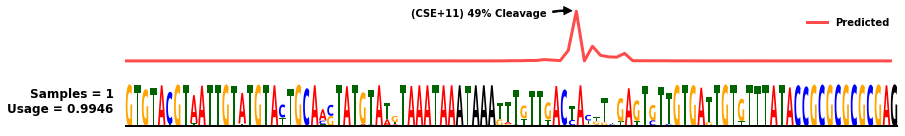

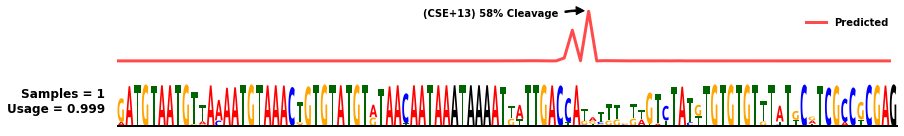

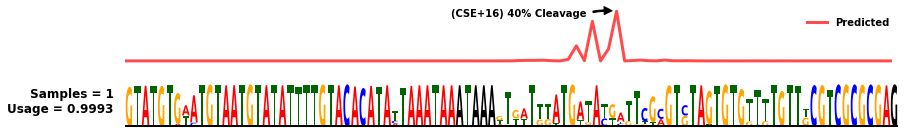

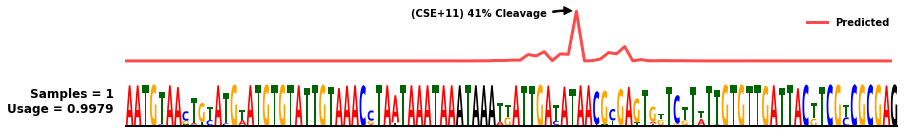

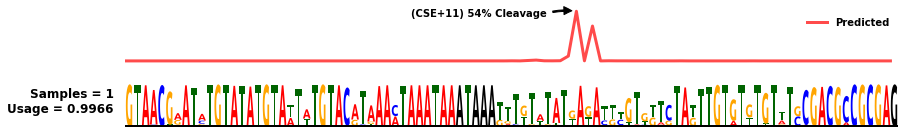

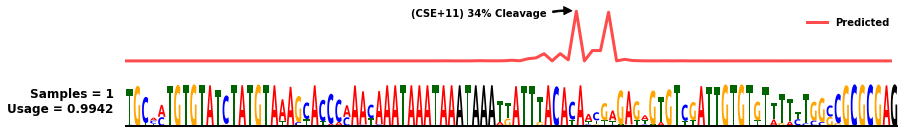

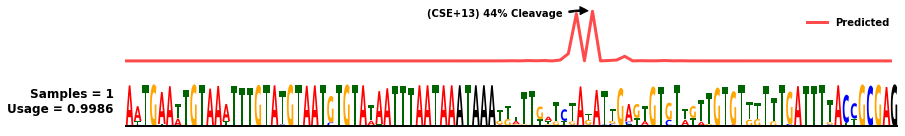

In [ ]:
obj_pos='max'#85

plot_start = 70-40
plot_end = 76+50

for pwm_index in range(8):#range(optimized_pwm.shape[0]) :
    plot_seqprop_logo(np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0), np.expand_dims(iso_pred[pwm_index, :], axis=0), np.expand_dims(cut_pred[pwm_index, :], axis=0), annotate_peaks=obj_pos, sequence_template=seq_template, figsize=(13, 2), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=plot_start, plot_end=plot_end, save_figs=False, fig_name=None, fig_dpi=300)

In [312]:
#Load pre-trained model
save_dir = os.path.join(os.getcwd(), '../saved_models')

#model_name = 'aparent_plasmid_iso_cut_distalpas_large_all_libs.h5'
#model_name = 'aparent_plasmid_iso_cut_distalpas_large_all_libs_no_sampleweights.h5'
model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'
#model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs.h5'

#model_name = 'aparent_plasmid_iso_cut_distalpas_libs_30_31_34.h5'
#model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs.h5'
#model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights.h5'
#model_name = 'aparent_plasmid_iso_cut_distalpas_less_dropout_all_libs.h5'
#model_name = 'aparent_plasmid_iso_cut_distalpas_less_dropout_all_libs_no_sampleweights.h5'

#model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights_nopseudo_sgd.h5'
#model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_batchnorm_all_libs_no_sampleweights_nopseudo_adam.h5'

model_path = os.path.join(save_dir, model_name)

predictor_model = load_model(model_path)

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [318]:
def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

seq = get_consensus_sequence(optimized_pwm[0, :, :, 0])
#seq = 'AAAAAAAAAAAAAAAAAAAAATCTTATAATTGTAACCTTGTACAAATGTAAAAATGTAAAAATGTATAAATATAAAATTTTTTAACCCTCAACTTGTCGTCTCCGCGTCTTCTTTCTTTCTCGTCGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
print(seq)

#seq = seq[:70] + "AATAAA" + seq[76:]
seq = ('X' * 20) + seq[20:]

one_hot = np.reshape(iso.OneHotEncoder(205)(seq), (1, 205, 4, 1))

fake_lib = np.zeros((1, 13))
#fake_lib[0, 0] = 1
iso_pred, cut_pred = predictor_model.predict([one_hot, fake_lib, np.ones((1, 1))])

print("iso_pred = " + str(iso_pred[0, 0]))
print("iso_logodds = " + str(np.log(iso_pred[0, 0] / (1.0 - iso_pred[0, 0]))))

#print("sum(cut_pred) = " + str(np.sum(cut_pred[0, 80:110])))


AAAAAAAAAAAAAAAAAAAAATCTTATTGTATCCCCAATGTATTGTATCCCCAATGTATTGTATATAAAATATAAAGTATTTTTTACACCACGTGTGTGTGTCTCGTTCTTTTTTTTCGCGCGCCGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG
iso_pred = 0.9998161
iso_logodds = 8.601041499862006


In [60]:
8.097448240022196 - 6.938345580235887

1.159102659786309

In [64]:
4.725672492859369 - 3.5770162220873227

1.148656270772046

In [27]:
print(len("AAAAAAAAAAAAAAAAAAAAATCTTATAATTGTAACCTTGTACAAATGTAAAAATGTAAAAATGTATAAA"))

70


In [36]:
#Load pre-trained model
model_name = 'aparent_plasmid_iso_cut_distalpas_large_all_libs.h5'
model_path = os.path.join(save_dir, model_name)
predictor_model_1 = load_model(model_path)

model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'
model_path = os.path.join(save_dir, model_name)
predictor_model_2 = load_model(model_path)

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [51]:
print(predictor_model_1.get_layer("dense_4").get_weights()[1][0])
print(predictor_model_2.get_layer("dense_4").get_weights()[1][0])

print(predictor_model_1.get_layer("dense_4").get_weights()[0][-13:])
print(predictor_model_2.get_layer("dense_4").get_weights()[0][-13:])

-0.5493712
-0.44616926
[[ 0.34168077]
 [ 0.34698337]
 [-0.9535417 ]
 [-0.9923204 ]
 [-0.30556664]
 [ 0.71145445]
 [-1.2675078 ]
 [ 0.4123411 ]
 [ 0.9243081 ]
 [-1.0653143 ]
 [ 1.0194281 ]
 [-0.60279775]
 [ 0.88167083]]
[[ 0.2693288 ]
 [ 0.24587543]
 [-0.91772294]
 [-0.96156085]
 [-0.22407421]
 [ 0.68068665]
 [-1.0811459 ]
 [ 0.3507374 ]
 [ 0.83582914]
 [-0.8929445 ]
 [ 0.9500588 ]
 [-0.5119573 ]
 [ 0.8106245 ]]


In [12]:
#seq_class_inputs_test = np.tile(np.array([[0]]), (36, 1))
seq_class_inputs_test = np.tile(np.array([[0], [1], [2], [3], [4], [5], [6], [7], [8]]), (4, 1))

In [13]:
#optimized_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred, _ = seqprop_model.predict([seq_class_inputs_test], batch_size=32)

In [14]:
pred_outputs = seqprop_model.predict([seq_class_inputs_test], batch_size=36)

optimized_pwm = pred_outputs[0]
optimized_pwm_logits = pred_outputs[2]
optimized_pwm_norm_logits = pred_outputs[4]

iso_pred = pred_outputs[6]
cut_pred = pred_outputs[7]


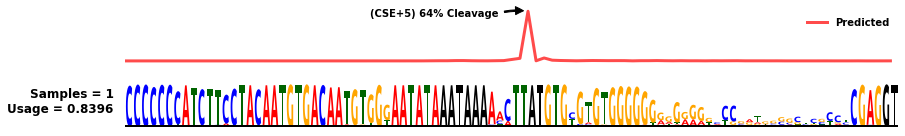

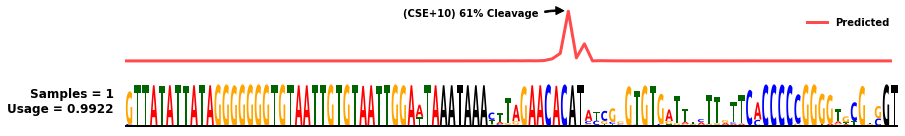

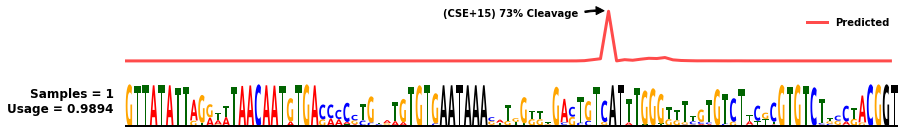

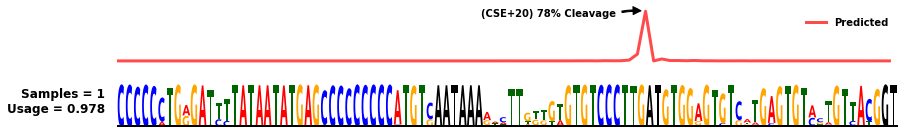

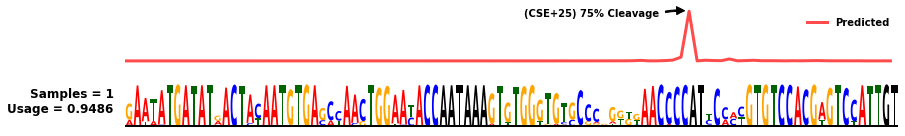

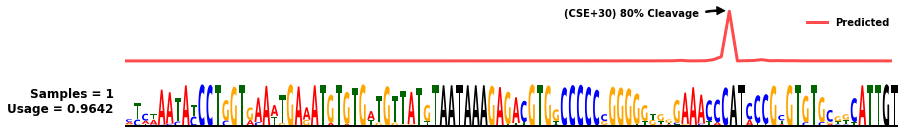

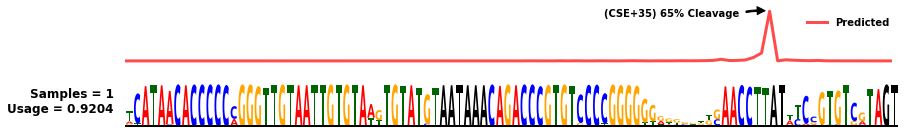

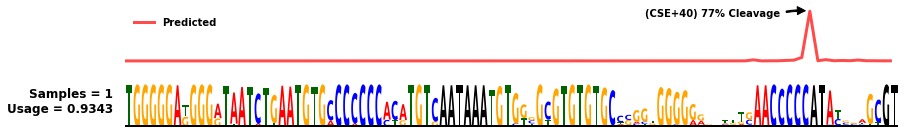

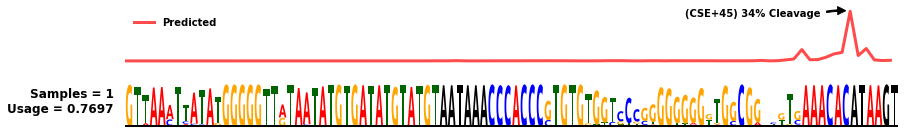

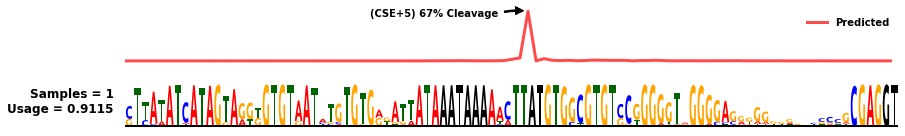

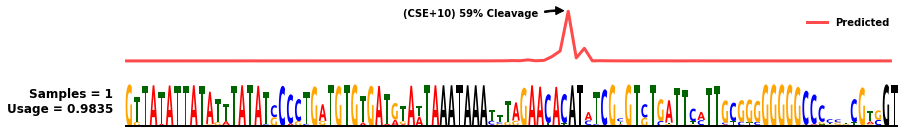

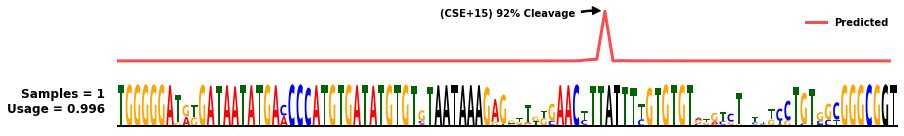

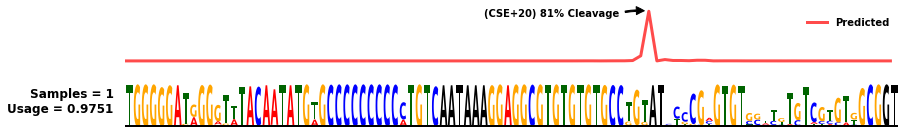

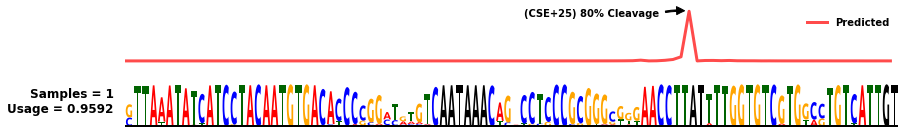

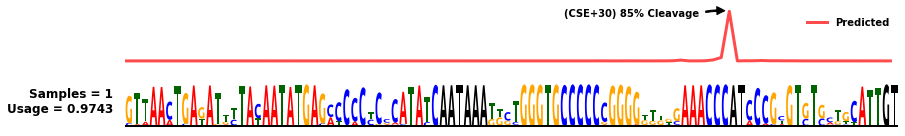

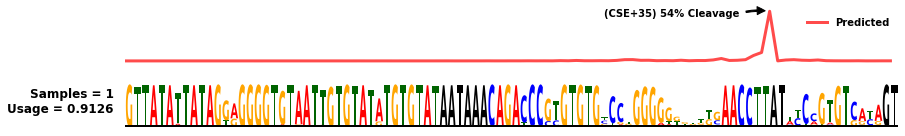

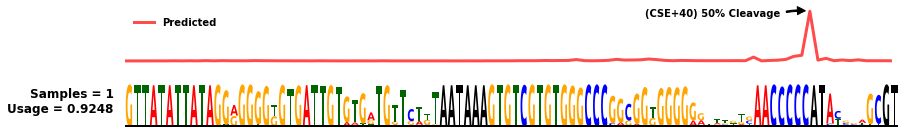

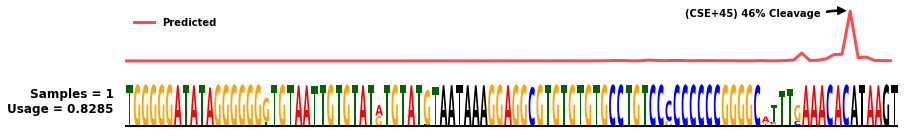

In [15]:
obj_pos='max'#85

plot_start = 70-40
plot_end = 76+50

for pwm_index in range(9 * 2):#range(optimized_pwm.shape[0]) :
    plot_seqprop_logo(np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0), np.expand_dims(iso_pred[pwm_index, :], axis=0), np.expand_dims(cut_pred[pwm_index, :], axis=0), annotate_peaks=obj_pos, sequence_template=seq_templates[pwm_index % n_classes], figsize=(13, 2), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=plot_start, plot_end=plot_end, save_figs=False, fig_name=None, fig_dpi=300)

In [16]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_multi_cuts.h5'
model_path = os.path.join(save_dir, model_name)
seqprop_model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at saved_models/genesis_multi_cuts.h5 


In [10]:
#Load seqforce model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_multi_cuts.h5'
model_path = os.path.join(save_dir, model_name)

seqprop_model = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

#Load pre-trained model
model_name = 'aparent_plasmid_iso_cut_distalpas_large_all_libs.h5'
model_path = os.path.join(save_dir, model_name)

predictor_model = load_model(model_path)

/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
seqprop_model.inputs

[<tf.Tensor 'sequence_class_1:0' shape=(?, 1) dtype=int32>,
 <tf.Tensor 'noise_input_1:0' shape=(36, 100) dtype=float32>,
 <tf.Tensor 'noise_input_2:0' shape=(36, 100) dtype=float32>,
 <tf.Tensor 'input_1_1:0' shape=(36, 13) dtype=float32>,
 <tf.Tensor 'input_2_1:0' shape=(36, 1) dtype=float32>]

In [12]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [13]:
n_classes = 9

seq_objectives = np.zeros((n_classes, 206), dtype=np.float)
seq_templates = []

seq_objectives[0, 80] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')
seq_objectives[1, 85] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')
seq_objectives[2, 90] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')
seq_objectives[3, 95] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')
seq_objectives[4, 100] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')
seq_objectives[5, 105] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')
seq_objectives[6, 110] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')
seq_objectives[7, 115] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')
seq_objectives[8, 120] = 1.
seq_templates.append('XXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT')


In [14]:

def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

n_sequences = 1000
n_sequences_ceil = int(n_sequences / 36) * 36 + 36

pwms = []
consensus_seqs = []
onehot_seqs = []
iso_preds = []
cut_preds = []
objectives = []

onehot_encoder = iso.OneHotEncoder(205)

for k in range(n_classes) :
    print('Predicting sequences for objective ' + str(k) + '...')
    
    
    
    seq_class_inputs_test = np.tile(np.array([[k]]), (n_sequences_ceil, 1))
    
    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    
    fake_lib_input = np.zeros((n_sequences_ceil, 13))
    fake_distal_pas = np.ones((n_sequences_ceil, 1))

    pred_outputs = seqprop_model.predict([seq_class_inputs_test, noise_1, noise_2, fake_lib_input, fake_distal_pas], batch_size=36)

    optimized_pwm = np.expand_dims(pred_outputs[0][:n_sequences, :, :, 0], axis=0)
    cut_pred = pred_outputs[7][:n_sequences, :]
    
    obj_ix = np.argmax(seq_objectives[k, :])
    iso_pred = np.expand_dims(np.sum(cut_pred[:, obj_ix-1:obj_ix+2], axis=-1), axis=0)
    cut_pred = np.expand_dims(cut_pred, axis=0)
    
    pwms.append(optimized_pwm)
    iso_preds.append(iso_pred)
    cut_preds.append(cut_pred)
    
    consensus_seqs.append([])
    onehot_seqs.append([])
    for i in range(n_sequences) :
        consensus_seqs[k].append(get_consensus_sequence(optimized_pwm[0, i, :, :]))
        onehot_seqs[k].append(onehot_encoder(get_consensus_sequence(optimized_pwm[0, i, :, :])))
    
    consensus_seqs[k] = np.expand_dims(np.array(consensus_seqs[k], dtype=np.object), axis=0)
    onehot_seqs[k] = np.expand_dims(onehot_seqs[k], axis=0)
    
    objectives.append(np.zeros((1, n_sequences)) + k)

pwms = np.concatenate(pwms, axis=0)
iso_preds = np.concatenate(iso_preds, axis=0)
cut_preds = np.concatenate(cut_preds, axis=0)
consensus_seqs = np.concatenate(consensus_seqs, axis=0)
onehot_seqs = np.concatenate(onehot_seqs, axis=0)
objectives = np.concatenate(objectives, axis=0)

print('pwms.shape = ' + str(pwms.shape))
print('iso_preds.shape = ' + str(iso_preds.shape))
print('cut_preds.shape = ' + str(cut_preds.shape))
print('consensus_seqs.shape = ' + str(consensus_seqs.shape))
print('onehot_seqs.shape = ' + str(onehot_seqs.shape))
print('objectives.shape = ' + str(objectives.shape))

Predicting sequences for objective 0...
Predicting sequences for objective 1...
Predicting sequences for objective 2...
Predicting sequences for objective 3...
Predicting sequences for objective 4...
Predicting sequences for objective 5...
Predicting sequences for objective 6...
Predicting sequences for objective 7...
Predicting sequences for objective 8...
pwms.shape = (9, 1000, 205, 4)
iso_preds.shape = (9, 1000)
cut_preds.shape = (9, 1000, 206)
consensus_seqs.shape = (9, 1000)
onehot_seqs.shape = (9, 1000, 205, 4)
objectives.shape = (9, 1000)


In [58]:

flat_onehot_seqs = np.reshape(onehot_seqs, (n_classes * n_sequences, 205 * 4))
flat_objectives = np.ravel(objectives)

obj_poses = np.argmax(seq_objectives, axis=1)

flat_labels = np.array(['CSE+' + str(obj_poses[int(k)] - 75) for k in flat_objectives.tolist()], dtype=np.object)

flat_onehot_seqs_opt = flat_onehot_seqs[:, 20*4:130*4]
flat_onehot_seqs_dse = flat_onehot_seqs[:, 76*4:120*4]


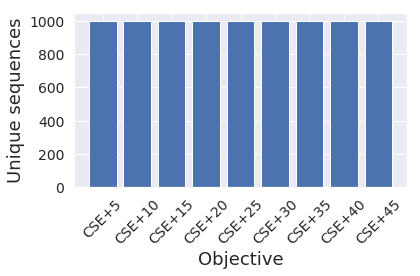

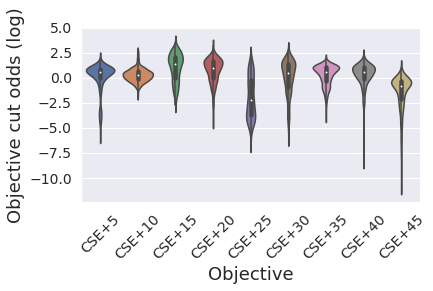

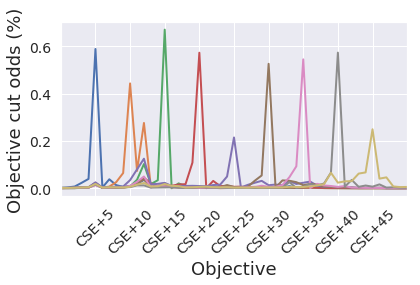

In [57]:
import seaborn as sns
sns.set()

#Uniquely generated sequences per objective

unique_counts = np.array([len(np.unique(consensus_seqs[k, :])) for k in range(n_classes)])

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(n_classes), unique_counts)#, edgecolor='darkgrey', linewidth=2, color='black'

plt.xticks(np.arange(n_classes), ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Unique sequences', fontsize=18)

plt.tight_layout()
plt.show()


#Objective cut log odds violin plot

cut_logodds = [np.log(iso_preds[k, :] / (1.0 - iso_preds[k, :])) for k in range(n_classes)]

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=cut_logodds)

plt.xticks(np.arange(n_classes), ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Objective cut odds (log)', fontsize=18)

plt.tight_layout()
plt.savefig('genesis_cut_magnitude.png', transparent=True, dpi=70)
plt.show()

#Average cut profile per objective

avgcut = np.mean(cut_preds[:, :, :-1] / np.expand_dims(np.sum(cut_preds[:, :, :-1], axis=-1), axis=-1), axis=1)

f = plt.figure(figsize=(6, 4))

for k in range(n_classes) :
    plt.plot(np.arange(205-75), avgcut[k, 75:], linewidth=2)

plt.xticks([obj_poses[int(k)] - 75 for k in range(n_classes)], ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlim(0, 50)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Objective cut odds (%)', fontsize=18)

plt.tight_layout()
plt.savefig('genesis_cut_distribution.png', transparent=True, dpi=70)
plt.show()

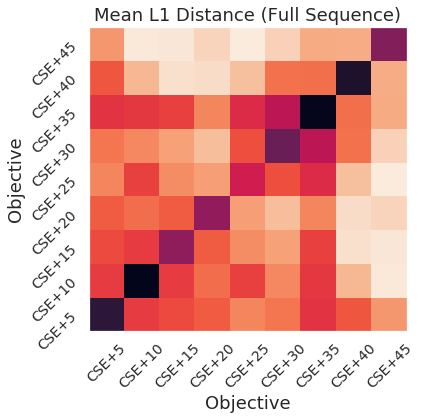

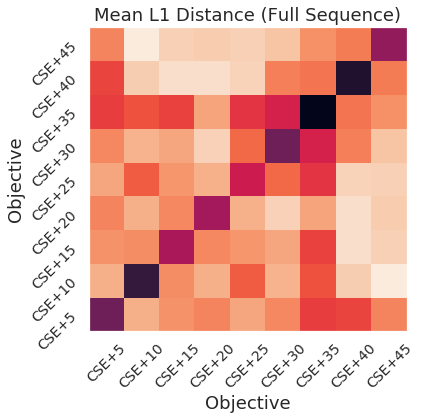

In [76]:
#One-hot L1-norm confusion matrix, full sequence

n_samples = 1000

l1_norms_fullseq = np.zeros((n_classes, n_classes))

for k1 in range(0, n_classes) :
    for k2 in range(k1, n_classes) :
        for sample_ix in range(n_samples) :
            rand_ix_1 = np.random.choice(np.arange(n_sequences))
            rand_ix_2 = np.random.choice(np.arange(n_sequences))

            rand_flat_onehot_1 = np.ravel(onehot_seqs[k1, rand_ix_1, 20: 130, :])
            rand_flat_onehot_2 = np.ravel(onehot_seqs[k2, rand_ix_2, 20: 130, :])
        
            rand_norm = np.linalg.norm(rand_flat_onehot_1 - rand_flat_onehot_2, ord=1)
            
            l1_norms_fullseq[k1, k2] += rand_norm
            if k1 != k2 :
                l1_norms_fullseq[k2, k1] += rand_norm


l1_norms_fullseq /= float(n_samples)

mean_norm = np.mean(l1_norms_fullseq)
l1_norms_fullseq - mean_norm

f = plt.figure(figsize=(6, 6))

plt.pcolor(l1_norms_fullseq)

plt.xticks(np.arange(n_classes) + 0.5, ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(np.arange(n_classes) + 0.5, ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)

plt.title('Mean L1 Distance (Full Sequence)', fontsize=18)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Objective', fontsize=18)

plt.tight_layout()
plt.show()


#One-hot L1-norm confusion matrix, DSE only

n_samples = 1000

l1_norms_fullseq = np.zeros((n_classes, n_classes))

for k1 in range(0, n_classes) :
    for k2 in range(k1, n_classes) :
        for sample_ix in range(n_samples) :
            rand_ix_1 = np.random.choice(np.arange(n_sequences))
            rand_ix_2 = np.random.choice(np.arange(n_sequences))

            rand_flat_onehot_1 = np.ravel(onehot_seqs[k1, rand_ix_1, 76: 120, :])
            rand_flat_onehot_2 = np.ravel(onehot_seqs[k2, rand_ix_2, 76: 120, :])
        
            rand_norm = np.linalg.norm(rand_flat_onehot_1 - rand_flat_onehot_2, ord=1)
            
            l1_norms_fullseq[k1, k2] += rand_norm
            if k1 != k2 :
                l1_norms_fullseq[k2, k1] += rand_norm


l1_norms_fullseq /= float(n_samples)

mean_norm = np.mean(l1_norms_fullseq)
l1_norms_fullseq - mean_norm

f = plt.figure(figsize=(6, 6))

plt.pcolor(l1_norms_fullseq)

plt.xticks(np.arange(n_classes) + 0.5, ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(np.arange(n_classes) + 0.5, ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)

plt.title('Mean L1 Distance (DSE Only)', fontsize=18)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Objective', fontsize=18)

plt.tight_layout()
plt.show()


Starting PCA...
Done with PCA.
Starting tSNE...
Done with tSNE.


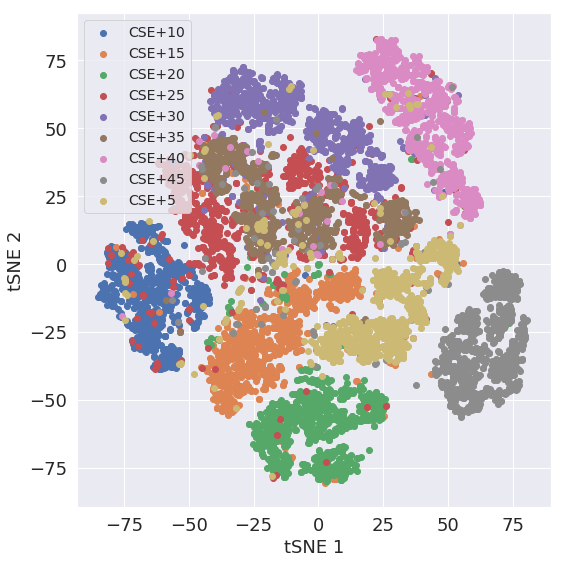

In [80]:
#PCA visualization, full sequence

print('Starting PCA...')

pca = PCA(n_components=50)
flat_onehot_seqs_pca = pca.fit_transform(flat_onehot_seqs_opt)

print('Done with PCA.')

#tSNE visualization

print('Starting tSNE...')

tsne = TSNE(n_components=2)
flat_onehot_seqs_tsne = tsne.fit_transform(flat_onehot_seqs_pca)

print('Done with tSNE.')

f = plt.figure(figsize = (8, 8))

for label in np.unique(flat_labels):
    plt.scatter(flat_onehot_seqs_tsne[flat_labels == label, 0], flat_onehot_seqs_tsne[flat_labels == label, 1], label=label)

plt.xlabel('tSNE 1', fontsize=18)
plt.ylabel('tSNE 2', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


Starting PCA...
Done with PCA.
Starting tSNE...
Done with tSNE.


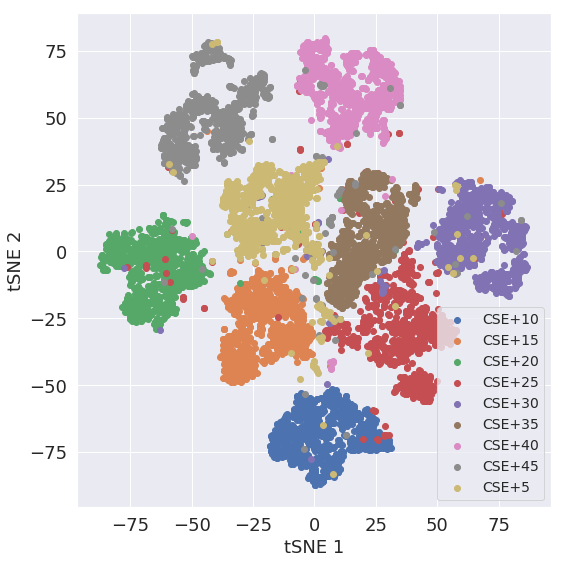

In [59]:
#PCA visualization, DSE only

print('Starting PCA...')

pca = PCA(n_components=50)
flat_onehot_seqs_pca = pca.fit_transform(flat_onehot_seqs_dse)

print('Done with PCA.')

#tSNE visualization

print('Starting tSNE...')

tsne = TSNE(n_components=2)
flat_onehot_seqs_tsne = tsne.fit_transform(flat_onehot_seqs_pca)

print('Done with tSNE.')

f = plt.figure(figsize = (8, 8))

for label in np.unique(flat_labels):
    plt.scatter(flat_onehot_seqs_tsne[flat_labels == label, 0], flat_onehot_seqs_tsne[flat_labels == label, 1], label=label)

plt.xlabel('tSNE 1', fontsize=18)
plt.ylabel('tSNE 2', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('genesis_dse_tsne.png', transparent=True, dpi=70)
plt.show()


In [17]:
#Comparison against experimental seqprop sequences

library_name = 'array_noacut_score_50'
library_version = 'unfiltered'

#Read dataframe and cut matrices
folder_path = '../apa_array/processed_data/' + library_version + '/'

df = pd.read_csv(folder_path + library_name + '_' + library_version + '_misprime_mapped.csv', delimiter=',').reset_index(drop=True)

cuts = spio.loadmat(folder_path + library_name + '_' + library_version + '_cuts.mat')['cuts']

print(len(df))


444220


In [18]:

def group_dataframe(df, cuts, min_total_count=1, drop_nans=False, nan_prox_range=[57, 87], misprime_filters=None, groupby_list=['master_seq']) :
    
    print('Collapsing with groupby = ' + str(groupby_list))
    
    df_copy = df.copy().reset_index(drop=True)
    
    cuts_dense = np.array(cuts.todense())[:, 20:]
    cuts_dense = np.hstack([cuts_dense, np.ravel(df_copy['distal_count'].values).reshape(-1, 1)])
    
    df_copy['cuts'] = cuts_dense.tolist()
    
    print('Filtering...')
    print('Size before filtering = ' + str(len(df_copy)))
    
    
    df_copy['prox_ratio_temp'] = np.sum(cuts_dense[:, nan_prox_range[0]:nan_prox_range[1]], axis=1) / np.sum(cuts_dense, axis=1)
    
    if drop_nans :
        df_copy = df_copy.query("total_count >= " + str(min_total_count) + " and prox_ratio_temp > 0.0 and prox_ratio_temp < 1.0").reset_index(drop=True)
    else :
        df_copy = df_copy.query("total_count >= " + str(min_total_count)).reset_index(drop=True)
    
    if misprime_filters is not None :
        misprime_query = ""
        experiment_i = 0
        for experiment in misprime_filters :
            if experiment != 'all' :
                misprime_query += "not (experiment == '" + experiment + "' and ("
            else :
                misprime_query += "not ("
            for filter_i, filter_id in enumerate(misprime_filters[experiment]) :
                misprime_query += filter_id + " == True"
                if filter_i < len(misprime_filters[experiment]) - 1 :
                    misprime_query += " or "
                else :
                    misprime_query += ")"
            if experiment_i < len(misprime_filters) - 1 :
                misprime_query += ") and "
            else :
                misprime_query += ")"

            experiment_i += 1

        df_copy = df_copy.query(misprime_query).reset_index(drop=True)
    
    print('Size after filtering = ' + str(len(df_copy)))
    
    df_group = df_copy.groupby(groupby_list)
    
    list_f = lambda x: tuple(x)
    
    agg_dict = {
        'experiment' : 'first',
        'subexperiment' : 'first',
        'gene' : 'first',
        'significance' : 'first',
        'clinvar_id' : 'first',
        'variant' : 'first',
        'in_acmg' : 'first',
        'sitetype' : 'first',
        'wt_seq' : 'first',
        'predicted_logodds' : 'first',
        'predicted_usage' : 'first',
        'barcode' : list_f,
        'proximal_count' : list_f,
        'distal_count' : list_f,
        'total_count' : list_f,
        'cuts' : lambda x: tuple([np.array(l) for l in x])#tuple(x.tolist())
    }
    
    df_agg = df_group.agg(agg_dict)
    
    print('Grouped dataframe.')
    
    return df_agg



def summarize_dataframe(df, min_barcodes=1, min_pooled_count=1, min_mean_count=1, prox_cut_start=55, prox_cut_end=85, isoform_pseudo_count=0, pooled_isoform_pseudo_count=0, cut_pseudo_count=0, drop_nans=False) :
    
    print('Filtering...')
    
    df['n_barcodes'] = df['barcode'].apply(lambda t: len(t))
    df['pooled_total_count'] = df['total_count'].apply(lambda t: np.sum(np.array(list(t))))
    df['mean_total_count'] = df['total_count'].apply(lambda t: np.mean(np.array(list(t))))
    
    df = df.query("n_barcodes >= " + str(min_barcodes) + " and pooled_total_count >= " + str(min_pooled_count) + " and mean_total_count >= " + str(min_mean_count)).copy()
    
    print('Summarizing...')
    
    df['pooled_cut_prob'] = df['cuts'].apply(lambda t: np.sum(np.array(list(t)) + cut_pseudo_count, axis=0) / np.sum(np.array(list(t)) + cut_pseudo_count))
    df['mean_cut_prob'] = df['cuts'].apply( lambda t: np.mean(np.vstack([ (x + cut_pseudo_count) / np.sum(x + cut_pseudo_count) for x in list(t) ]), axis=0) )
    
    df['proximal_count'] = df['cuts'].apply(lambda t: tuple([np.sum(x[prox_cut_start: prox_cut_end]) for x in t]))
    
    proximal_distrib = df['cuts'].apply(lambda t: tuple([(x[prox_cut_start: prox_cut_end] + cut_pseudo_count) / np.sum(x[prox_cut_start: prox_cut_end] + cut_pseudo_count) for x in t]))
    df['proximal_avgcut'] = proximal_distrib.apply(lambda t: tuple([np.sum(x * (np.arange(prox_cut_end - prox_cut_start))) for x in t]))
    
    df['pooled_proximal_count'] = df['proximal_count'].apply(lambda t: np.sum(np.array(list(t))))
    df['pooled_distal_count'] = df['distal_count'].apply(lambda t: np.sum(np.array(list(t))))
    
    df['proximal_usage'] = df.apply(lambda row: tuple([(p + isoform_pseudo_count) / (t + 2. * isoform_pseudo_count) for p, t in zip(list(row['proximal_count']), list(row['total_count']))]), axis=1)
    df['proximal_logodds'] = df['proximal_usage'].apply(lambda t: tuple([np.log(p / (1. - p)) for p in list(t)]))
    
    df['pooled_proximal_usage'] = (df['pooled_proximal_count'] + pooled_isoform_pseudo_count) / (df['pooled_total_count'] + 2. * pooled_isoform_pseudo_count)
    df['mean_proximal_usage'] = df['proximal_usage'].apply(lambda t: np.mean(list(t)))
    df['median_proximal_usage'] = df['proximal_usage'].apply(lambda t: np.median(list(t)))
    df['std_proximal_usage'] = df['proximal_usage'].apply(lambda t: np.std(list(t)))
    
    df['pooled_proximal_logodds'] = np.log(df['pooled_proximal_usage'] / (1. - df['pooled_proximal_usage']))
    df['mean_proximal_logodds'] = df['proximal_logodds'].apply(lambda t: np.mean(list(t)))
    df['median_proximal_logodds'] = df['proximal_logodds'].apply(lambda t: np.median(list(t)))
    df['std_proximal_logodds'] = df['proximal_logodds'].apply(lambda t: np.std(list(t)))
    
    df['mean_proximal_avgcut'] = df['proximal_avgcut'].apply(lambda t: np.mean(list(t)))
    df['median_proximal_avgcut'] = df['proximal_avgcut'].apply(lambda t: np.median(list(t)))
    df['std_proximal_avgcut'] = df['proximal_avgcut'].apply(lambda t: np.std(list(t)))
    
    
    #Proximal Vs. Distal
    df['competing_count'] = df['cuts'].apply(lambda t: tuple([np.sum(x[:prox_cut_start]) for x in t]))
    df['pooled_competing_count'] = df['competing_count'].apply(lambda t: np.sum(np.array(list(t))))
    
    
    df['proximal_vs_distal_usage'] = df.apply(lambda row: tuple([(p + isoform_pseudo_count) / (p + c + d + 2. * isoform_pseudo_count) for p, c, d in zip(list(row['proximal_count']), list(row['competing_count']), list(row['distal_count']))]), axis=1)
    df['proximal_vs_distal_logodds'] = df['proximal_vs_distal_usage'].apply(lambda t: tuple([np.log(p / (1. - p)) for p in list(t)]))
    df['pooled_proximal_vs_distal_usage'] = (df['pooled_proximal_count'] + pooled_isoform_pseudo_count) / (df['pooled_proximal_count'] + df['pooled_competing_count'] + df['pooled_distal_count'] + 2. * pooled_isoform_pseudo_count)
    df['mean_proximal_vs_distal_usage'] = df['proximal_vs_distal_usage'].apply(lambda t: np.mean(list(t)))
    df['median_proximal_vs_distal_usage'] = df['proximal_vs_distal_usage'].apply(lambda t: np.median(list(t)))
    df['pooled_proximal_vs_distal_logodds'] = np.log(df['pooled_proximal_vs_distal_usage'] / (1. - df['pooled_proximal_vs_distal_usage']))
    df['mean_proximal_vs_distal_logodds'] = df['proximal_vs_distal_logodds'].apply(lambda t: np.mean(list(t)))
    df['median_proximal_vs_distal_logodds'] = df['proximal_vs_distal_logodds'].apply(lambda t: np.median(list(t)))
    
    
    print('Dropping intermediate columns...')
    
    if drop_nans == True :
        df['pooled_proximal_logodds_is_nan'] = np.isnan(df['pooled_proximal_logodds']) | np.isinf(df['pooled_proximal_logodds'])
        df['mean_proximal_logodds_is_nan'] = np.isnan(df['mean_proximal_logodds']) | np.isinf(df['mean_proximal_logodds'])
        df['mean_proximal_avgcut_nan'] = np.isnan(df['mean_proximal_avgcut']) | np.isinf(df['mean_proximal_avgcut'])
        
        df = df.query("pooled_proximal_logodds_is_nan == False and mean_proximal_logodds_is_nan == False").copy()# and mean_proximal_avgcut_nan == False
        
        df = df.drop(columns=['pooled_proximal_logodds_is_nan', 'mean_proximal_logodds_is_nan', 'mean_proximal_avgcut_nan'])

    
    df = df.drop(columns=['barcode', 'total_count', 'proximal_count', 'distal_count', 'proximal_usage', 'proximal_logodds', 'proximal_vs_distal_usage', 'proximal_vs_distal_logodds', 'cuts', 'proximal_avgcut'])
    
    df = df.reset_index()
    
    return df


misprime_filters = {
    'max_iso' : ['misprime_16_of_20'],
    'max_cut' : ['misprime_16_of_20'],
    'tgta' : ['misprime_16_of_20'],
    
    'clinvar_wt' : ['misprime_10_of_12', 'misprime_12_of_16', 'misprime_15_of_20'],
    'clinvar_mut' : ['misprime_10_of_12', 'misprime_12_of_16', 'misprime_15_of_20'],
    'intronic_pas' : ['misprime_10_of_12', 'misprime_12_of_16', 'misprime_15_of_20'],
    'acmg_apadb' : ['misprime_10_of_12', 'misprime_12_of_16', 'misprime_15_of_20'],
    'acmg_polyadb' : ['misprime_10_of_12', 'misprime_12_of_16', 'misprime_15_of_20'],
    'sensitive_genes' : ['misprime_10_of_12', 'misprime_12_of_16', 'misprime_15_of_20'],
    'human variant' : ['misprime_10_of_12', 'misprime_12_of_16', 'misprime_15_of_20'],
}

seq_df_group = group_dataframe(df, cuts, min_total_count=100, drop_nans=False, misprime_filters=misprime_filters, groupby_list=['master_seq'])

seq_df = summarize_dataframe(
                    seq_df_group,
                    min_barcodes=1,
                    min_pooled_count=1,
                    min_mean_count=1,
                    prox_cut_start=57,#49,#57,
                    prox_cut_end=87,#90,#87,
                    isoform_pseudo_count=1.0,
                    pooled_isoform_pseudo_count=2.0,
                    cut_pseudo_count=0.0005,
                    drop_nans=False
)

print('Size = ' + str(len(seq_df)))

Collapsing with groupby = ['master_seq']
Filtering...
Size before filtering = 444220
Size after filtering = 323890
Grouped dataframe.
Filtering...
Summarizing...
Dropping intermediate columns...
Size = 39833


In [21]:
#Re-annotate SNV mutations against Clinvar

clinvar_snv_df = pd.read_csv('../apa_array/clinvar_predictions.csv', delimiter=('\t'))
clinvar_snv_df['master_seq'] = clinvar_snv_df['var'].str.slice(0, 164)
clinvar_snv_df = clinvar_snv_df.set_index('master_seq')
clinvar_snv_df = clinvar_snv_df[['significance', 'clinvar_id', 'observed_usage', 'in_acmg']]

clinvar_snv_df = clinvar_snv_df.rename({'observed_usage' : 'apadb_usage'})


seq_df['significance'] = 'Missing'
seq_df['clinvar_id'] = 'Missing'
seq_df['in_acmg'] = 'No'
seq_df.loc[(seq_df.experiment == 'acmg_apadb') | (seq_df.experiment == 'acmg_polyadb'), 'in_acmg'] = 'Yes'
seq_df['apadb_logodds'] = np.nan

seq_df = seq_df.join(clinvar_snv_df, on='master_seq', how='left', rsuffix='_clinvarcopy').copy()

valid_index = seq_df['clinvar_id_clinvarcopy'].notna()

seq_df.loc[valid_index, 'clinvar_id'] = seq_df.loc[valid_index, 'clinvar_id_clinvarcopy']
seq_df.loc[valid_index, 'significance'] = seq_df.loc[valid_index, 'significance_clinvarcopy']
seq_df.loc[valid_index, 'in_acmg'] = seq_df.loc[valid_index, 'in_acmg_clinvarcopy']
seq_df.loc[valid_index, 'apadb_logodds'] = seq_df.loc[valid_index, 'observed_usage']

seq_df = seq_df.drop(columns=['clinvar_id_clinvarcopy', 'significance_clinvarcopy', 'in_acmg_clinvarcopy', 'observed_usage']).copy()



#Re-map snv variants to wt sequences

def hamming_distance(seq1, seq2) :
    dist = 0
    for j in range(0, len(seq1)) :
        if seq1[j] != seq2[j] :
            dist += 1
    
    return dist


wt_dict = {}
for index, row in seq_df.iterrows() :
    
    if row['variant'] == 'wt' :
        wt_gene = row['gene']
        if 'MAN_' in wt_gene :
            wt_gene = wt_gene.replace('MAN_', '')
        
        #wt_gene = wt_gene[:wt_gene.index('.')]
        
        if wt_gene not in wt_dict :
            wt_dict[wt_gene] = []
        
        wt_dict[wt_gene].append(row['master_seq'])

#Append special case wt mappings
wt_dict['HBB.2'].extend(wt_dict['HBB.3'])

wt_seqs = []
for index, row in seq_df.iterrows() :
    
    wt_seq = row['wt_seq']
    
    if wt_seq == 'Unmapped' and row['gene'] in wt_dict :
        if row['variant'] == 'snv' :
            for wt_seq_candidate in wt_dict[row['gene']] :
                if hamming_distance(row['master_seq'], wt_seq_candidate) == 1 :
                    wt_seq = wt_seq_candidate
                    break
        elif row['variant'] == 'indel' and len(wt_dict[row['gene']]) == 1 :
            if hamming_distance(row['master_seq'][:20], wt_dict[row['gene']][0][:20]) == 0 :
                wt_seq = wt_dict[row['gene']][0]
    
    wt_seqs.append(wt_seq)

seq_df['wt_seq'] = wt_seqs


#Map TGTA variants to wt sequence

tgta_wts = list(seq_df.query("experiment == 'tgta' and subexperiment == 'n=0'")['master_seq'].values)

tgta_wts.extend(list(seq_df.loc[(seq_df.master_seq.str.contains('AGAGGATCAATCCCATCAGTGG')) & (seq_df.subexperiment == 'n=1')]['master_seq'].values))

wt_seqs = []
tgta_fixed = []
for index, row in seq_df.iterrows() :
    
    wt_seq = row['wt_seq']
    
    if wt_seq == 'Unmapped' and row['experiment'] == 'tgta' :
        min_dist = 30
        min_wt_seq = 'Unmapped'
        for wt_seq_candidate in tgta_wts :
            hamming_dist = hamming_distance(row['master_seq'], wt_seq_candidate)
            
            if hamming_dist < min_dist :
                min_dist = hamming_dist
                min_wt_seq = wt_seq_candidate
        
        wt_seq = min_wt_seq
    
    wt_seqs.append(wt_seq)
    
    if 'AGAGGATCAATCCCATCAGTGG' in row['master_seq'] :
        tgta_fixed.append(True)
    else :
        tgta_fixed.append(False)

seq_df['wt_seq'] = wt_seqs
seq_df['tgta_fixed'] = tgta_fixed

#Map TGTA mut positions

tgta_pos_1_list = []
tgta_pos_2_list = []
tgta_pos_3_list = []


for index, row in seq_df.iterrows() :
    
    tgta_pos_1 = 0
    tgta_pos_2 = 0
    tgta_pos_3 = 0
    
    if row['experiment'] == 'tgta' :
        
        tgta_start_pos = 0
        
        if row['subexperiment'] in ['n=1', 'n=2', 'n=3'] :
            
            for j in range(tgta_start_pos, len(row['master_seq']) - 3) :
                if row['master_seq'][j:j+4] != row['wt_seq'][j:j+4] and row['master_seq'][j:j+4] == 'TGTA' :
                    tgta_start_pos = j
                    break
            
            tgta_pos_1 = tgta_start_pos
        if row['subexperiment'] in ['n=2', 'n=3'] :
            for j in range(tgta_start_pos + 4, len(row['master_seq']) - 3) :
                if row['master_seq'][j:j+4] != row['wt_seq'][j:j+4] and row['master_seq'][j:j+4] == 'TGTA' :
                    tgta_start_pos = j
                    break
            
            tgta_pos_2 = tgta_start_pos
    
    tgta_pos_1_list.append(tgta_pos_1)
    tgta_pos_2_list.append(tgta_pos_2)
    tgta_pos_3_list.append(tgta_pos_3)

seq_df['tgta_pos_1'] = tgta_pos_1_list
seq_df['tgta_pos_2'] = tgta_pos_2_list
seq_df['tgta_pos_3'] = tgta_pos_3_list

pred_version = 'unfiltered_grouped_seq_count_10_dropnans_False_predicted_isoform_dropout_d'

folder_path = '../apa_array/processed_data/unfiltered/predictions/'

predicted_isoform_df = pd.read_csv(folder_path + 'array_' + pred_version + '.csv', delimiter=',').reset_index(drop=True)
predicted_isoform_df['cut_index_pred'] = np.ravel(predicted_isoform_df.index.values)

print(len(predicted_isoform_df))

predicted_isoform_df = predicted_isoform_df.rename(index=str, columns={"predicted_usage": "proximal_usage_pred", "predicted_logodds": "proximal_logodds_pred"})
predicted_isoform_df = predicted_isoform_df[['master_seq', 'proximal_usage_pred', 'proximal_logodds_pred']]

cuts_version = 'unfiltered_grouped_seq_count_10_dropnans_False_predicted_cuts_dropout_pasaligned_d'

predicted_cuts = spio.loadmat(folder_path + 'array_' + cuts_version + '.mat')['cuts']

print(predicted_cuts.shape)

predicted_cuts_dense = np.hstack([np.zeros((predicted_cuts.shape[0], 1)), np.array(predicted_cuts.todense())])
predicted_isoform_df['cut_prob_pred'] = predicted_cuts_dense.tolist()
predicted_isoform_df['cut_prob_pred'] = predicted_isoform_df['cut_prob_pred'].apply(lambda x: np.array(x))


seq_predicted_isoform_df = seq_df.set_index('master_seq').join(predicted_isoform_df.set_index('master_seq'), lsuffix='_true', rsuffix='_pred', how='inner')

print(len(seq_predicted_isoform_df))


seq_predicted_isoform_df = seq_predicted_isoform_df.rename(
    index=str,
    columns={
        "mean_proximal_usage": "mean_proximal_usage_true",
        "pooled_proximal_usage": "pooled_proximal_usage_true",
        "mean_proximal_logodds": "mean_proximal_logodds_true",
        "pooled_proximal_logodds": "pooled_proximal_logodds_true",
        "mean_proximal_vs_distal_usage": "mean_proximal_vs_distal_usage_true",
        "pooled_proximal_vs_distal_usage": "pooled_proximal_vs_distal_usage_true",
        "mean_proximal_vs_distal_logodds": "mean_proximal_vs_distal_logodds_true",
        "pooled_proximal_vs_distal_logodds": "pooled_proximal_vs_distal_logodds_true",
        
        "median_proximal_usage": "median_proximal_usage_true",
        "median_proximal_logodds": "median_proximal_logodds_true",
        "median_proximal_vs_distal_usage": "median_proximal_vs_distal_usage_true",
        "median_proximal_vs_distal_logodds": "median_proximal_vs_distal_logodds_true",
        
        "mean_cut_prob": "mean_cut_prob_true",
        "pooled_cut_prob": "pooled_cut_prob_true"
    }
)

unique_experiments = seq_predicted_isoform_df.query("experiment == 'max_cut'")['subexperiment'].unique()

#cut_df_filtered = seq_predicted_isoform_df.query("experiment == 'max_cut' and mean_total_count >= 10 and variant != 'snv'").copy()
#cut_snv_df_filtered = seq_predicted_isoform_df.query("experiment == 'max_cut' and mean_total_count >= 10 and variant == 'snv'").copy()
cut_df_filtered = seq_predicted_isoform_df.query("experiment == 'max_cut' and mean_total_count >= 10").copy()

#Map and evaluate sequences
def eval_logloss(cut_prob, target_pos) :
    target = np.zeros(cut_prob.shape[0])
    target[target_pos] = 0.8
    target[target_pos - 1] = 0.10
    target[target_pos + 1] = 0.10
    
    ent = -np.dot(target, np.log((cut_prob + 0.001) / np.sum(cut_prob + 0.001)))
    
    return ent

start_pos = 58
end_pos = 108

cut_poses = np.arange(end_pos - start_pos) + (start_pos - 56)

true_cut_column = 'pooled_cut_prob_true'
pred_cut_column = 'cut_prob_pred'

avg_position_true = []
avg_position_pred = []
cut_probs_true = []
cut_probs_pred = []
log_loss = []
for index, row in cut_df_filtered.iterrows() :
    
    cut_prob_true = np.ravel(row[true_cut_column])
    cut_prob_true = cut_prob_true[start_pos:end_pos] / np.sum(cut_prob_true[start_pos:end_pos])
    cut_probs_true.append(cut_prob_true)

    cut_prob_pred = np.ravel(row[pred_cut_column])
    cut_prob_pred = cut_prob_pred[start_pos:end_pos] / np.sum(cut_prob_pred[start_pos:end_pos])
    cut_probs_pred.append(cut_prob_pred)
    
    avg_pos_true = np.dot(cut_prob_true, (np.arange(cut_prob_true.shape[0]) + start_pos))
    avg_pos_pred = np.dot(cut_prob_pred, (np.arange(cut_prob_pred.shape[0]) + start_pos))
    avg_position_true.append(avg_pos_true)
    avg_position_pred.append(avg_pos_pred)
    
    cut_pos_caught = False
    for cut_pos in [60, 65, 70, 75, 80, 85, 90, 95, 100] :
        if str(cut_pos) in row['subexperiment'] :            
            log_loss.append(eval_logloss(np.copy(cut_prob_true), cut_pos - 55 - (start_pos - 56)))
            
            cut_pos_caught = True
            break
    
    if not cut_pos_caught :
        log_loss.append(0)
    

cut_df_filtered['proxcut_prob_true'] = cut_probs_true
cut_df_filtered['proxcut_prob_pred'] = cut_probs_pred
cut_df_filtered['avgpos_true'] = avg_position_true
cut_df_filtered['avgpos_pred'] = avg_position_pred
cut_df_filtered['loss_logloss'] = log_loss

cut_snv_df_filtered = cut_df_filtered.query("variant == 'snv'").copy()
cut_df_filtered = cut_df_filtered.query("variant != 'snv'").copy()

print("Total number of Max Cut sequences = " + str(len(cut_df_filtered)))

objective_poses = [5, 10, 15, 20, 25, 30, 35, 40, 45]

seq_objective_df = cut_df_filtered.copy().reset_index()[['master_seq', 'experiment', 'subexperiment', 'variant', 'gene', 'pooled_proximal_usage_true', 'pooled_cut_prob_true', 'avgpos_true']]

47273
(47273, 186)
39833
Total number of Max Cut sequences = 1274


In [28]:
#Map and collect array data

cut_nt = 'AT'
aruns_objective = ''#_aruns
ggcc_objective = ''#_GGCC
subexperiments = {
    0 : [cut_nt + ggcc_objective + aruns_objective + '_60', cut_nt + ggcc_objective + aruns_objective + '_ent_60'],#, cut_nt + aruns_objective + '_ent_60'
    1 : [cut_nt + ggcc_objective + aruns_objective + '_65', cut_nt + ggcc_objective + aruns_objective + '_ent_65'],#, cut_nt + aruns_objective + '_ent_65'],
    2 : [cut_nt + ggcc_objective + aruns_objective + '_70', cut_nt + ggcc_objective + aruns_objective + '_ent_70'],#, cut_nt + aruns_objective + '_ent_70'],
    3 : [cut_nt + ggcc_objective + aruns_objective + '_75', cut_nt + ggcc_objective + aruns_objective + '_ent_75'],#, cut_nt + aruns_objective + '_ent_75'],
    4 : [cut_nt + ggcc_objective + aruns_objective + '_80', cut_nt + ggcc_objective + aruns_objective + '_ent_80'],#, cut_nt + aruns_objective + '_ent_80'],
    5 : [cut_nt + ggcc_objective + aruns_objective + '_85', cut_nt + ggcc_objective + aruns_objective + '_ent_85'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_85'],
    6 : [cut_nt + ggcc_objective + aruns_objective + '_90', cut_nt + ggcc_objective + aruns_objective + '_ent_90'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_90'],
    7 : [cut_nt + ggcc_objective + aruns_objective + '_95', cut_nt + ggcc_objective + aruns_objective + '_ent_95'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_95'],
    8 : [cut_nt + ggcc_objective + aruns_objective + '_100', cut_nt + ggcc_objective + aruns_objective + '_ent_100'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_100'],
}

array_seqs = []
array_onehot_seqs = []
array_cut_preds = []
array_avg_poses = []
array_objectives = []
array_seqtypes = []

onehot_encoder = iso.OneHotEncoder(163)

for k in range(n_classes) :
    print('Collecting sequences for objective ' + str(k) + '...')
    
    sel_df = seq_objective_df.loc[seq_objective_df.subexperiment.isin(subexperiments[k])].copy()
    sel_df['master_seq'] = sel_df.master_seq.str.slice(1, 164)
    
    print('n_sequences = ' + str(len(sel_df)))
    
    array_seqs.append(list(sel_df.master_seq.values))
    array_seqs[k] = np.array(array_seqs[k], dtype=np.object)
    
    array_onehot_seqs.append([])
    for i in range(len(sel_df)) :
        array_onehot_seqs[k].append(onehot_encoder(array_seqs[k][i]))
    
    array_onehot_seqs[k] = np.array(array_onehot_seqs[k])
    
    cut_pred = np.array(list(sel_df['pooled_cut_prob_true'].values))
    array_cut_preds.append(cut_pred)
    
    avg_pos = np.array(list(sel_df['avgpos_true'].values))
    array_avg_poses.append(avg_pos)
    
    array_objectives.append(np.zeros(len(sel_df)) + k)
    
    array_seqtypes.append([])
    array_seqtypes[k] = np.array(list(sel_df['variant'].values), dtype=np.object)



n_sequences = 34
n_sequences = 32
n_sequences = 28
n_sequences = 33
n_sequences = 34
n_sequences = 34
n_sequences = 33
n_sequences = 34
n_sequences = 34


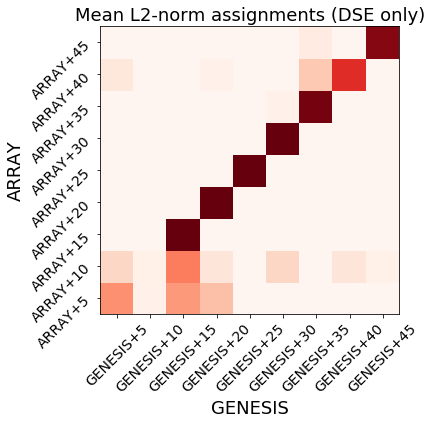

In [42]:
#One-hot L2-norm cluster centroid confusion matrix, DSE only

cluster_means = np.mean(onehot_seqs[:, :, 76:125, :], axis=1).reshape(n_classes, -1)

l2_min_assignments = np.zeros((n_classes, n_classes))

for k in range(0, n_classes) :
    for i in range(0, array_onehot_seqs[k].shape[0]) :
        l2_distances = np.linalg.norm(cluster_means - array_onehot_seqs[k][i, 56:105, :].reshape(1, -1), ord=1, axis=-1)
        l2_min_ix = np.argmin(l2_distances)
        
        l2_min_assignments[k, l2_min_ix] += 1


l2_min_assignments = l2_min_assignments / np.sum(l2_min_assignments, axis=1).reshape(-1, 1)

f = plt.figure(figsize=(6, 6))

plt.pcolor(l2_min_assignments, cmap='Reds', vmin=0, vmax=1)

plt.xticks(np.arange(n_classes) + 0.5, ['GENESIS+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(np.arange(n_classes) + 0.5, ['ARRAY+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)

plt.title('Mean L2-norm assignments (DSE only)', fontsize=18)

plt.xlabel('GENESIS', fontsize=18)
plt.ylabel('ARRAY', fontsize=18)

plt.tight_layout()
plt.savefig('genesis_knn_array.png', transparent=True, dpi=70)
plt.show()

